In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [5]:
# Our so-called "masterlist" - a merge of CTCF and RAD21 peaks - as a collection of
# biologically relevant sites to look at ...
feat_names = OrderedDict()
feat_names["rad_ctcf_union"] = "union_RAD21_CTCF.bed"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [6]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)


### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


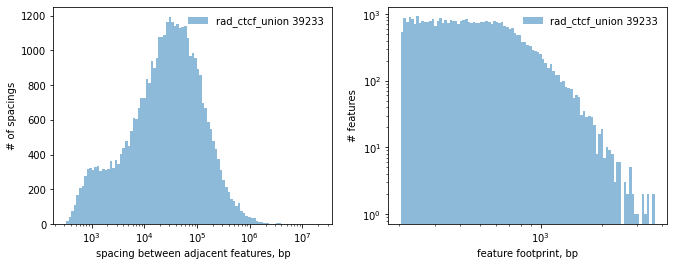

In [7]:
plot_spacing_footprint_distros(dfs)

### let's have the original CTCF and RAD21 peak calls here to count them along our stackups as well (kind of sliding window, but not really sliding ...) ...

Also we agreed to add matching motif analyses here - G4-seq(not quite a motif, but just another way to get at G4-s) and FIMO-scanned CTCF `MA0139.1` motifs as well ...

##### Let's load called ChipSeq peaks for our "grey-plots" ("quantifications") here ...

In [8]:
# bioframe is short for bioframe here ...
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)
# ctcf_df = bf.merge(ctcf_df, min_dist=merge_radius)

In [9]:
rad21_df = bioframe.read_table(
    "NT-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
rad21_df = rad21_df.sort_values(["chrom","start"])
rad21_df = rad21_df[ rad21_df["chrom"].isin(autosomal_chroms) ]
rad21_df = rad21_df.reset_index(drop=True)
# rad21_df = bf.merge(rad21_df, min_dist=merge_radius)

In [10]:
rad21_IAA_df = bioframe.read_table(
    "IAA-RAD21-narrowPeaks-sort-merge",
    names=["chrom","start","end"]
)
rad21_IAA_df = rad21_IAA_df.sort_values(["chrom","start"])
rad21_IAA_df = rad21_IAA_df[ rad21_IAA_df["chrom"].isin(autosomal_chroms) ]
rad21_IAA_df = rad21_IAA_df.reset_index(drop=True)
# rad21_IAA_df = bf.merge(rad21_IAA_df, min_dist=merge_radius)

##### We also need CTCF motifs for the grey plots ("quantifications") here as well ...

In [11]:
### CTCF motif: http://jaspar.genereg.net/matrix/MA0139.1/
jaspar_url = 'http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2018/hg19/tsv/'
jaspar_motif_file = 'MA0139.1.tsv.gz'
ctcf_motif = bioframe.read_table(
                jaspar_url+jaspar_motif_file,
                skiprows=1,
                names=["chrom", "start", "end","name","score", "pval", "strand"]
)
ctcf_motif = ctcf_motif.sort_values(["chrom","start"])
ctcf_motif = ctcf_motif[ ctcf_motif["chrom"].isin(autosomal_chroms) ]
ctcf_motif = ctcf_motif.reset_index(drop=True)

# beforehand we used FIMO to find motifs in the hg19 - ourselves
# it seems to match the published one - OK - so we'll use the published one:
# # here is very-very liberal list of CTCF calls in hg19, based on "MA0139.1.meme" from JASPAR
# # P-val cutoff was 1e-4 - let's see how it looks here ...
# !scp ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/CTCF_motif/CTCF.hist.txt ./CTCF.MA0139.1.txt

##### We also need G4 data for the grey plots ("quantifications") here as well ...

In [12]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")
# G4_polstall.head()

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [13]:
#let's describe our samples that we want to have in Figure 1 ...
fig1_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2"]

titles = fig1_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig1_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [14]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks(bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features rad_ctcf_union:(39233) ...


stacking up ctcf ...
CPU times: user 6.13 s, sys: 543 ms, total: 6.68 s
Wall time: 6.63 s
stacking up noctcf ...
CPU times: user 5.6 s, sys: 534 ms, total: 6.13 s
Wall time: 6.11 s
stacking up rad21_CTCF ...
CPU times: user 6.66 s, sys: 672 ms, total: 7.33 s
Wall time: 7.33 s
stacking up rad21_noCTCF ...
CPU times: user 5.22 s, sys: 555 ms, total: 5.78 s
Wall time: 5.76 s
stacking up ins_CTCF ...
CPU times: user 5.1 s, sys: 450 ms, total: 5.55 s
Wall time: 5.5 s
stacking up ins_noCTCF ...
CPU times: user 5 s, sys: 643 ms, total: 5.65 s
Wall time: 5.64 s
stacking up G4a_r2 ...
CPU times: user 8.81 s, sys: 850 ms, total: 9.66 s
Wall time: 9.64 s


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [15]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in stackup_dict:
    the_stackup = stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [16]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.02)
    cmps[s] = cmapYlGnBu_r

### starting with some sorting, keeping legacy sorting approaches for now

In [52]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    length,width = the_stackups['ctcf'].shape
    center_bin = int(width/2)
    # ctcf is a narrow signal - so sorting on 2 bins around cener should be ok ...
    the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    _, _jjj = recursive_data_ordering(
                ks = [('ctcf_mean', "sort", 1, False)],
                idxs = np.arange( length ),
                data_dict = the_stackups,
                verbose=True,
    )
    reordered_jdxs[feature_key] = _jjj



sorting 39233 elements of ctcf_mean into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [58]:
CHUNK_SIZE = 100

ctcf_peaks_sorted = {}
rad21_peaks_sorted = {}
ctcf_motif_sorted = {}
G4_polstall_sorted = {}
# for defining the size of the grey plots ...
Number_of_chunks = {}

for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key].loc[jjj][["chrom","start","end"]].reset_index(drop=True)
    #######################################################
    #
    #######################################################
    print("preparing quantification for ctcf_peaks_sorted ...")
    _overlap_counts = bioframe.count_overlaps( features_df, ctcf_df )
    # shouldn't be any duplicated features ...
    assert ~ _overlap_counts.duplicated(subset=["chrom","start","end"]).any()
    ctcf_peaks_sorted[feature_key] = _overlap_counts["count"] \
                                        .rolling(window=CHUNK_SIZE) \
                                        .sum() \
                                        .iloc[CHUNK_SIZE-1::CHUNK_SIZE] \
                                        .values
    #    
    print("preparing quantification for rad21_peaks_sorted ...")
    _overlap_counts = bioframe.count_overlaps( features_df, rad21_df )
    # shouldn't be any duplicated features ...
    assert ~ _overlap_counts.duplicated(subset=["chrom","start","end"]).any()
    rad21_peaks_sorted[feature_key] = _overlap_counts["count"] \
                                        .rolling(window=CHUNK_SIZE) \
                                        .sum() \
                                        .iloc[CHUNK_SIZE-1::CHUNK_SIZE] \
                                        .values
    # do we need rad21IAA_peaks_sorted here ?

    # CTCF motif preparing for the "grey"-plot
    print("preparing quantification for ctcf_motif_sorted ...")
    _overlap_counts = bioframe.count_overlaps( features_df, ctcf_motif )
    # shouldn't be any duplicated features ...
    assert ~ _overlap_counts.duplicated(subset=["chrom","start","end"]).any()
    ctcf_motif_sorted[feature_key] = _overlap_counts["count"] \
                                        .rolling(window=CHUNK_SIZE) \
                                        .sum() \
                                        .iloc[CHUNK_SIZE-1::CHUNK_SIZE] \
                                        .values

    # G4_polstall
    print("preparing quantification for G4_polstall_sorted ...")
    _overlap_counts = bioframe.count_overlaps( features_df, G4_polstall )
    # shouldn't be any duplicated features ...
    assert ~ _overlap_counts.duplicated(subset=["chrom","start","end"]).any()
    G4_polstall_sorted[feature_key] = _overlap_counts["count"] \
                                        .rolling(window=CHUNK_SIZE) \
                                        .sum() \
                                        .iloc[CHUNK_SIZE-1::CHUNK_SIZE] \
                                        .values
    Number_of_chunks[feature_key] = len(G4_polstall_sorted[feature_key])


preparing quantification for ctcf_peaks_sorted ...
preparing quantification for rad21_peaks_sorted ...
preparing quantification for ctcf_motif_sorted ...
preparing quantification for G4_polstall_sorted ...


#### plotting those running averages is integrated into `plot_stackups` function ...

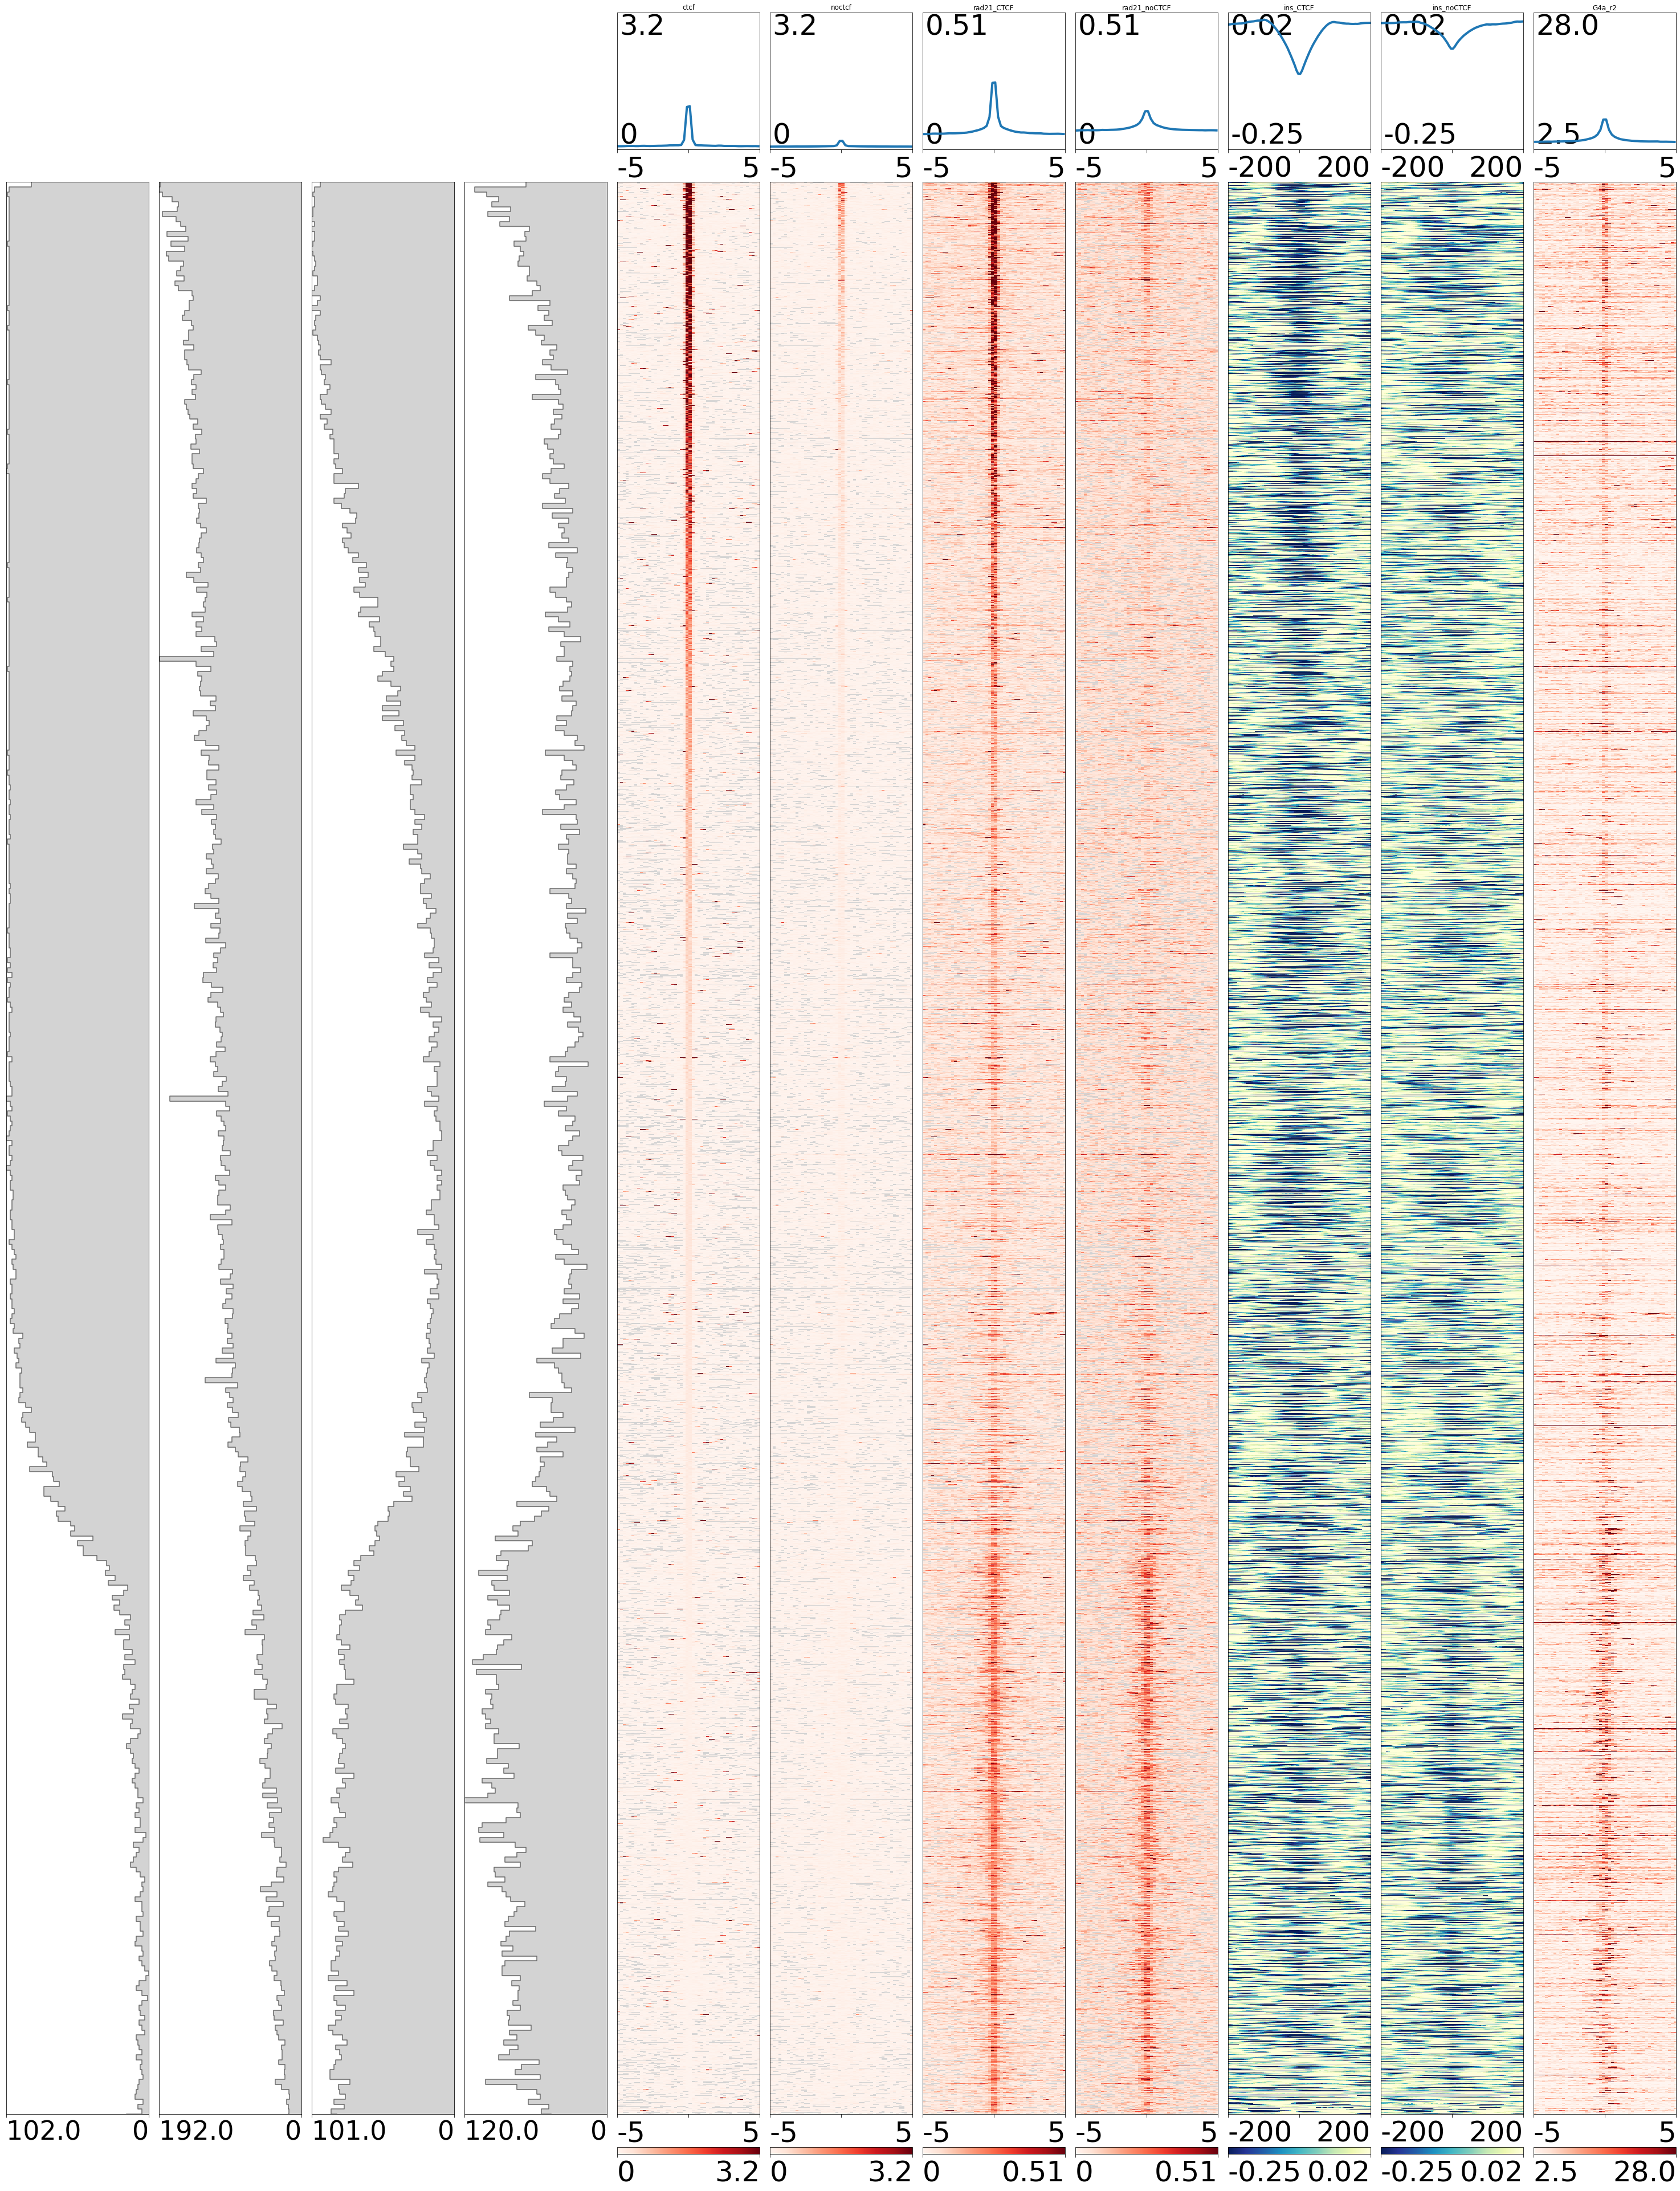

In [59]:
hmss = OrderedDict()

for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig1_samples ]

_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

extra_order = [0,1,2,3]
hmss_order = [4,5,6,7,8,9,10]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...
for idx, width in enumerate([ctcf_peaks_sorted, ctcf_motif_sorted, rad21_peaks_sorted, G4_polstall_sorted]):
    y, color = Number_of_chunks, "lightgrey"
    common_width_max = max(np.nanmax(width[k]) for k in width)
    col_index = extra_order[idx]
    for i, feature_key in enumerate(stackup_dict):
        _y = np.arange(y[feature_key])
        _width = width[feature_key]
        _color = color
        xtra_axs[col_index][i].step(_width,_y,color="dimgray")
        xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
        xtra_axs[col_index][i].invert_yaxis()
        xtra_axs[col_index][i].invert_xaxis()
        xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
        xtra_axs[col_index][i].set_ylim(max(_y), 0)
        xtra_axs[col_index][i].set_xlim(common_width_max,0)
        xtra_axs[col_index][i].set_yticks([])
        xtra_axs[col_index][i].set_yticklabels([])   
        xtra_axs[col_index][i].set_xticks([])
        xtra_axs[col_index][i].set_xticklabels([])   
        xtra_axs[col_index][i].set_xticks([common_width_max,0])
        xtra_axs[col_index][i].set_xticklabels([common_width_max,0],fontsize=46)
        for _tidx, tick in enumerate(xtra_axs[col_index][i].xaxis.get_majorticklabels()):
            if _tidx == 0:
                tick.set_horizontalalignment("left")
            elif _tidx == 1:
                tick.set_horizontalalignment("right")
        xtra_axs[col_index][i].tick_params(axis="x", length=6)

        
plt.savefig("Fig1_masterlist_all.pdf")

### let's plot zoom-ins into CTCF dependent and CTCF independent subsets ...

sorting 10000 elements of G4_mean into 1 groups ...


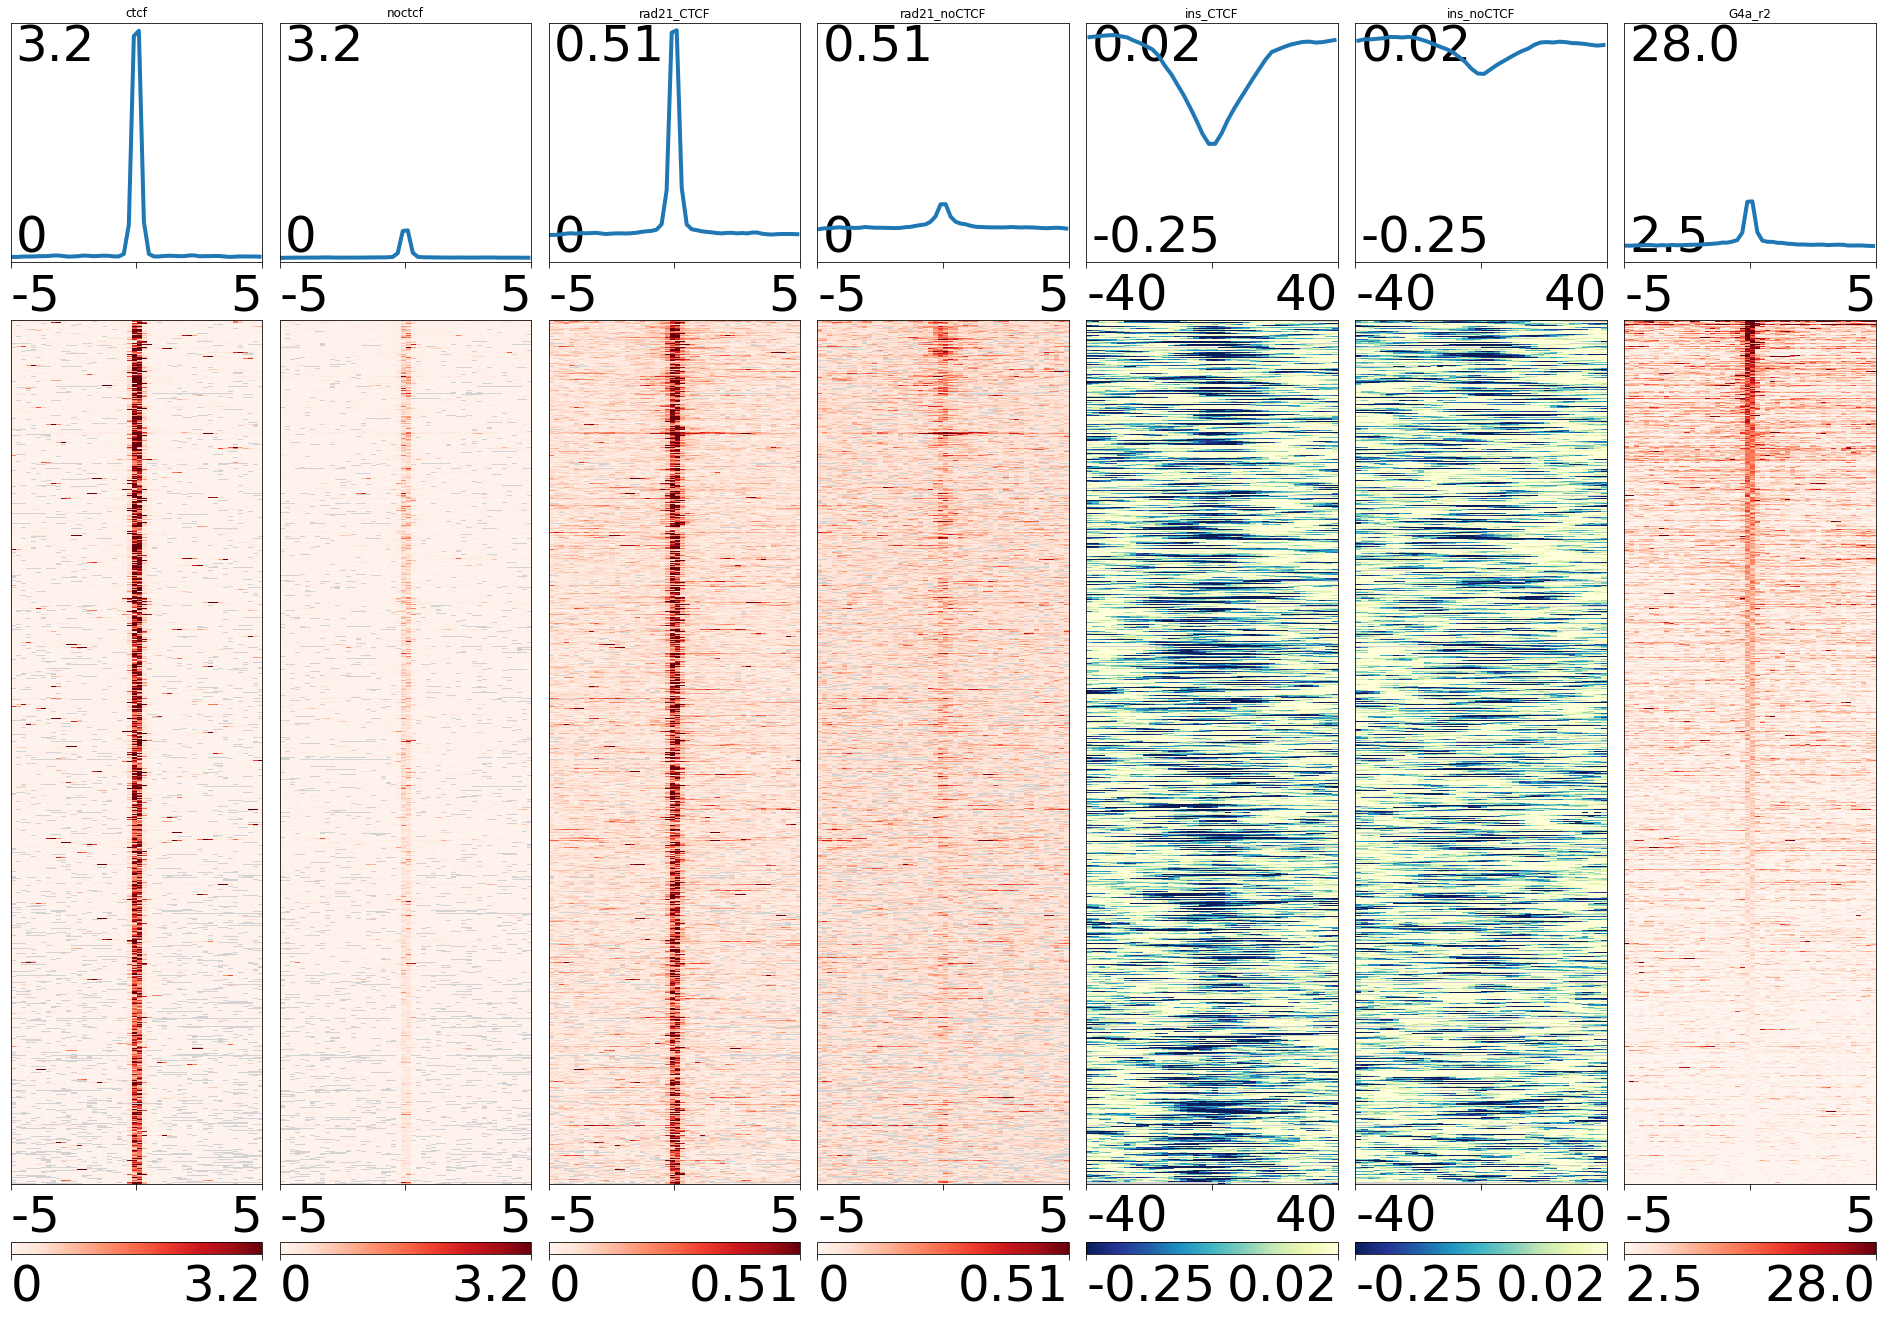

In [136]:
hmss = OrderedDict()
for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    #
    # let's take ~10'000 strongest CTCF harboring RAD21 peak
    iii = jjj[:10_000]
    _l, _w = _stackups['G4a_r2'].shape
    _cent = int(_w/2)
    tmp_dict = {}
    tmp_dict['G4_mean'] = np.nanmean(_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

    ks = [('G4_mean', "sort", 1, False)]
    _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)
    #
    hmss[feature_key] = [ _stackups[_k][iii[iii_reord]] for _k in fig1_samples ]

_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

plt.savefig("Fig1_masterlist_CTCFdep.pdf")

# there is only 1 feature we care about in this case ...
feature_key = "rad_ctcf_union"
dfs[feature_key].loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFdependent.bed",sep="\t",index=False,header=False)


sorting 10000 elements of G4_mean into 1 groups ...


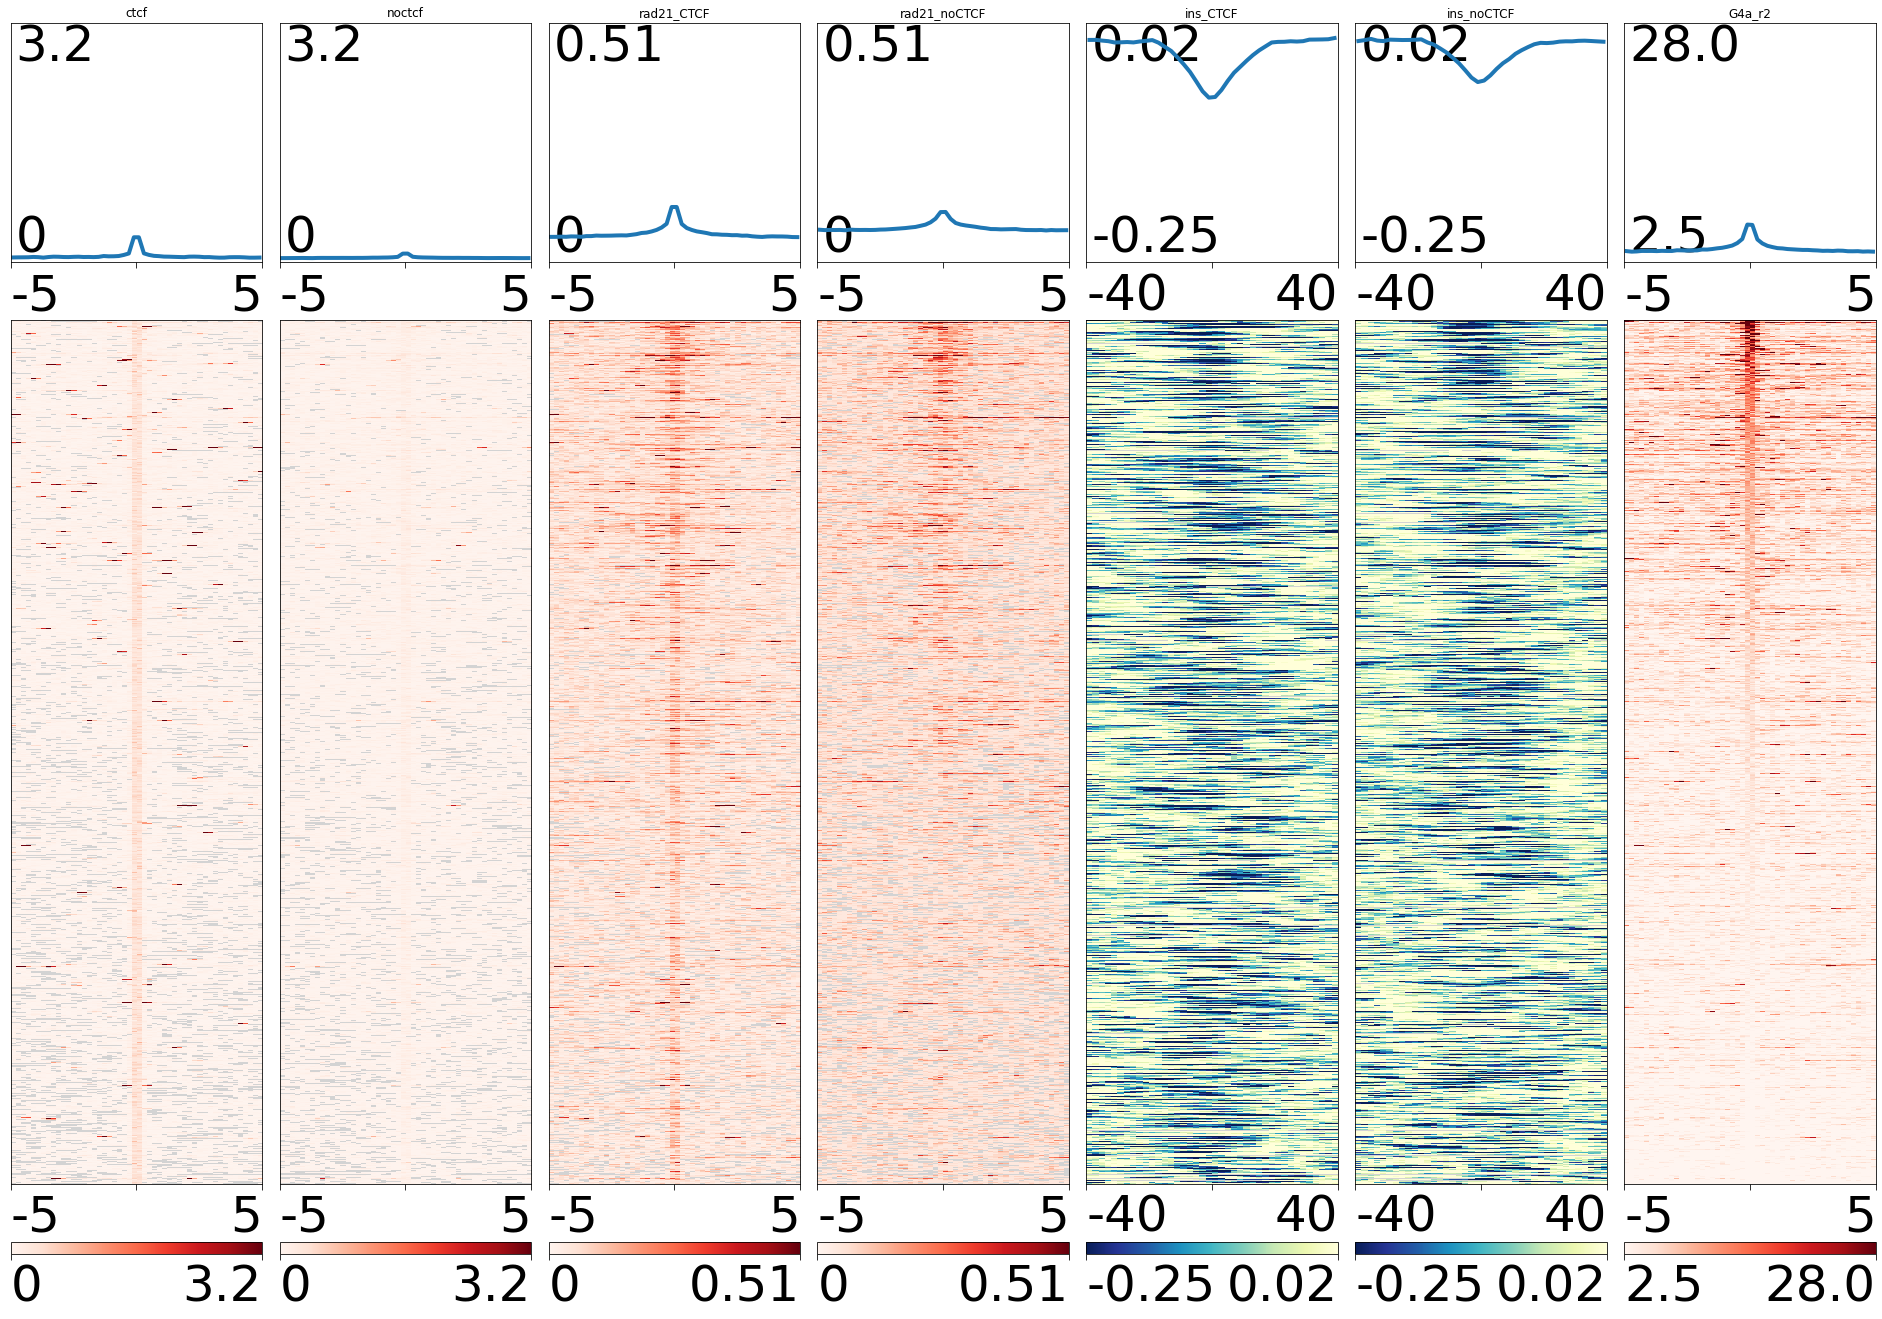

In [137]:
## Average CTCF strength - just for fun  ....

hmss = OrderedDict()
for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    #
    # let's take middle-ground CTCF harboring RAD21 peak
    iii = jjj[15_000:25_000]
    _l, _w = _stackups['G4a_r2'].shape
    _cent = int(_w/2)
    tmp_dict = {}
    tmp_dict['G4_mean'] = np.nanmean(_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

    ks = [('G4_mean', "sort", 1, False)]
    _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)
    #
    hmss[feature_key] = [ _stackups[_k][iii[iii_reord]] for _k in fig1_samples ]

_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

sorting 10000 elements of G4_mean into 1 groups ...


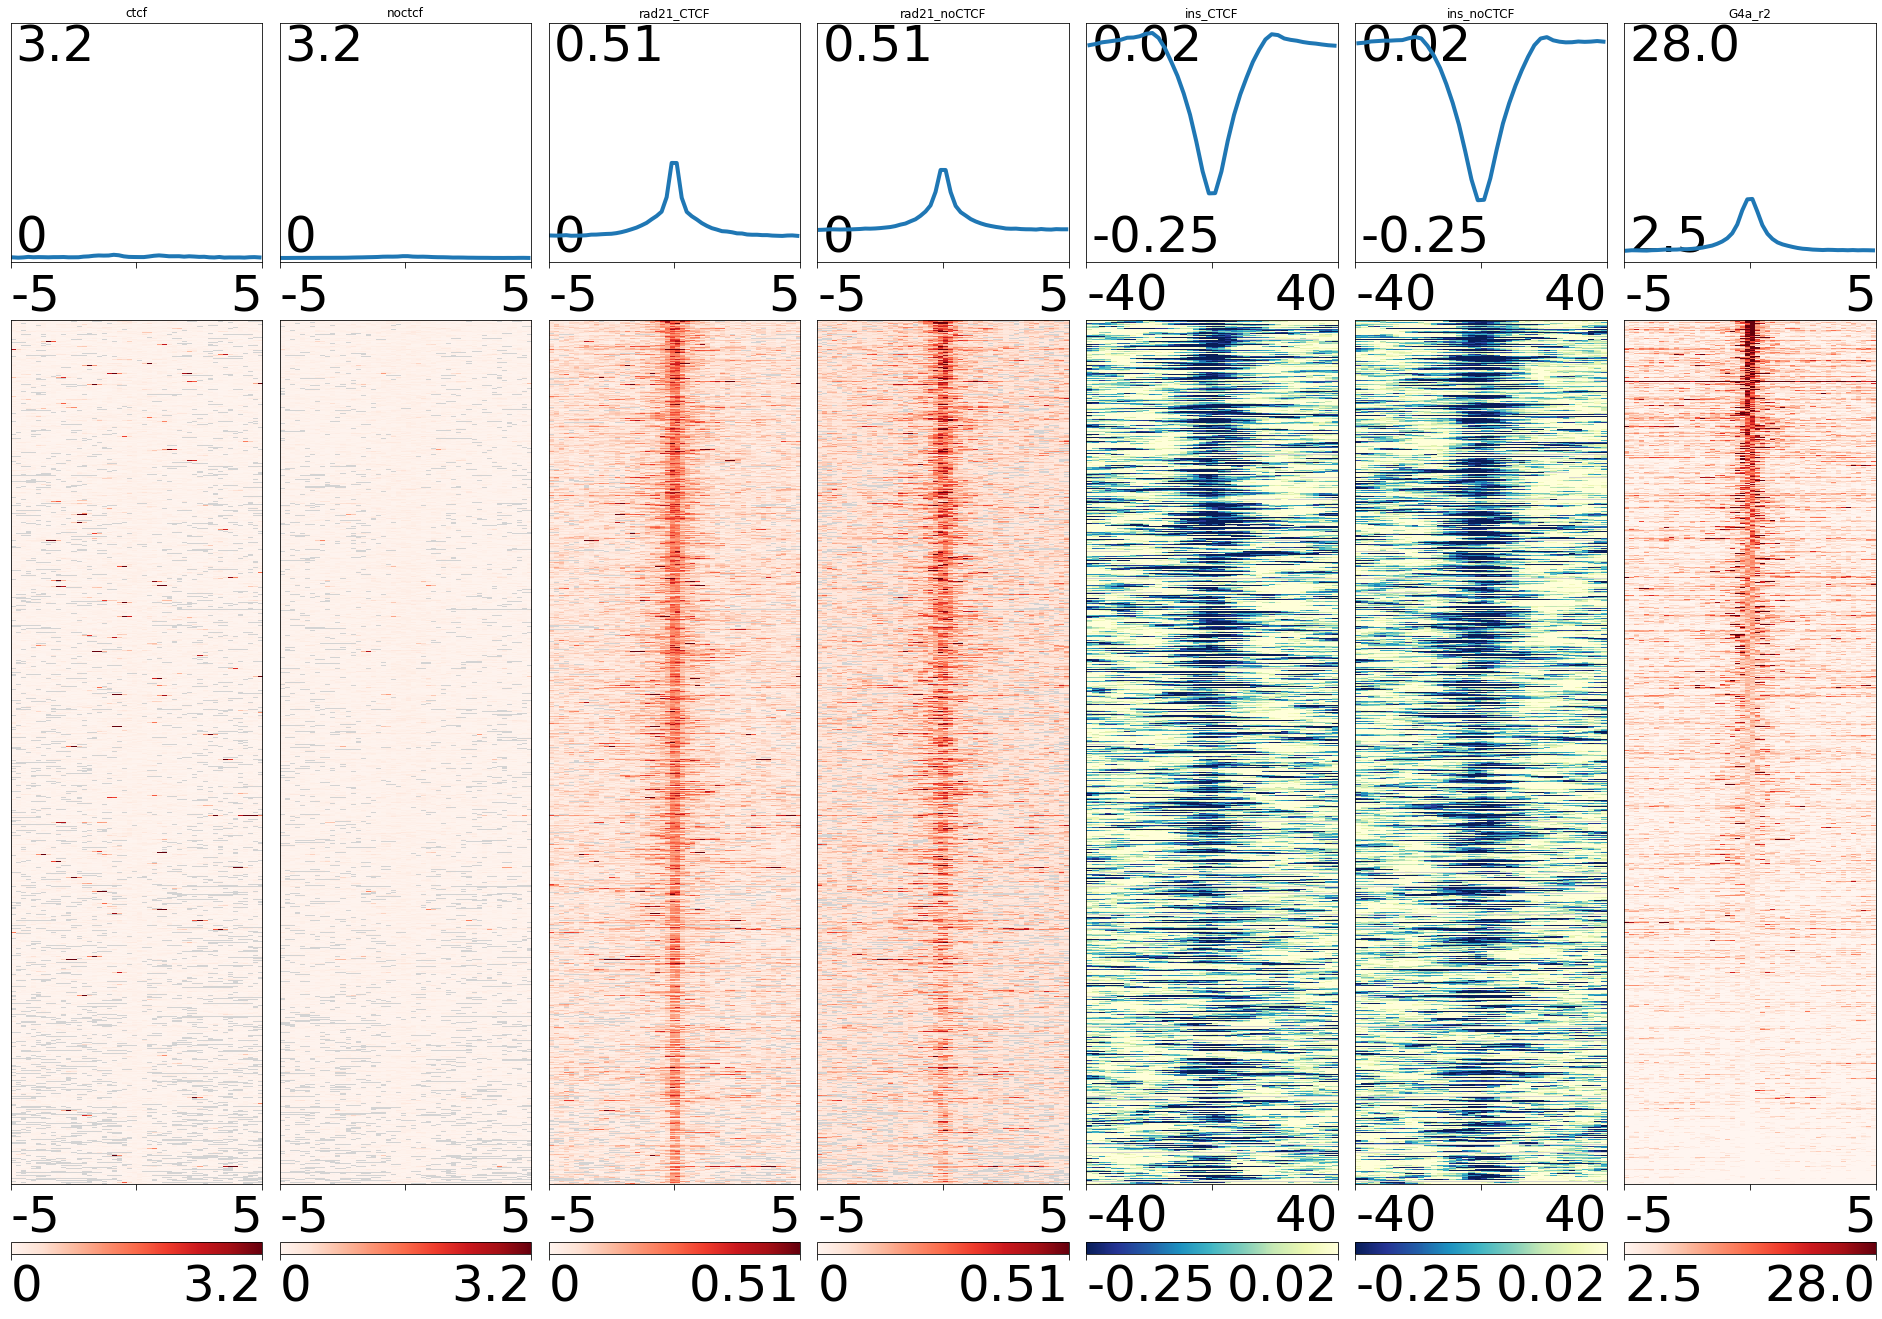

In [138]:
hmss = OrderedDict()
for feature_key in stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    #
    # let's take ~10'000  CTCF independent harboring RAD21 peaks
    iii = jjj[-10_000:]
    _l, _w = _stackups['G4a_r2'].shape
    _cent = int(_w/2)
    tmp_dict = {}
    tmp_dict['G4_mean'] = np.nanmean(_stackups['G4a_r2'][iii,_cent-1:_cent+1],axis=1)

    ks = [('G4_mean', "sort", 1, False)]
    _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)
    #
    hmss[feature_key] = [ _stackups[_k][iii[iii_reord]] for _k in fig1_samples ]

_limss = [ limss[_k] for _k in fig1_samples ]
_cmps = [ cmps[_k] for _k in fig1_samples ]
_binsizes = [ binsizes[_k] for _k in fig1_samples ]
_norms = [ norms[_k] for _k in fig1_samples ]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

plt.savefig("Fig1_masterlist_CTCFindep.pdf")

# there is only 1 feature we care about in this case ...
feature_key = "rad_ctcf_union"
dfs[feature_key].loc[ iii[iii_reord] ][["chrom","start","end"]].to_csv("masterlist_CTCFindependent.bed",sep="\t",index=False,header=False)


In [139]:
# check what we have here locally ...
# ! ls Fig1*pdf
# ! ls master*bed
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021

In [133]:
!ls -lah Fig1_masterlist_all*

-rw-rw-r-- 1 sergpolly sergpolly 2.5M Jul  1 15:44 Fig1_masterlist_all.pdf


In [140]:
!scp Fig1_masterlist* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig1_masterlist_all.pdf                       100% 2487KB 444.3KB/s   00:05    
Fig1_masterlist_CTCFdep.pdf                   100%  940KB 448.6KB/s   00:02    
Fig1_masterlist_CTCFindep.pdf                 100%  922KB 453.5KB/s   00:02    
Fig1_masterlist_CTCFmiddle.pdf                100%  512KB 466.1KB/s   00:01    
